In [231]:
import pandas as pd
import numpy as np

In [232]:
# Load dataset
df = pd.read_csv("All_States_GE.csv")
df.head()
df.tail()
df.columns

C:\Users\Joel\AppData\Local\Temp\ipykernel_69340\1727227126.py:2: DtypeWarning: Columns (17,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("All_States_GE.csv")


Index(['State_Name', 'Assembly_No', 'Constituency_No', 'Year', 'month',
       'Poll_No', 'DelimID', 'Position', 'Candidate', 'Sex', 'Party', 'Votes',
       'Candidate_Type', 'Valid_Votes', 'Electors', 'Constituency_Name',
       'Constituency_Type', 'Sub_Region', 'N_Cand', 'Turnout_Percentage',
       'Vote_Share_Percentage', 'Deposit_Lost', 'Margin', 'Margin_Percentage',
       'ENOP', 'pid', 'Party_Type_TCPD', 'Party_ID', 'last_poll', 'Contested',
       'Last_Party', 'Last_Party_ID', 'Last_Constituency_Name',
       'Same_Constituency', 'Same_Party', 'No_Terms', 'Turncoat', 'Incumbent',
       'Recontest', 'MyNeta_education', 'TCPD_Prof_Main',
       'TCPD_Prof_Main_Desc', 'TCPD_Prof_Second', 'TCPD_Prof_Second_Desc',
       'Election_Type'],
      dtype='object')

In [233]:
df = df.drop(['Election_Type', 'month', 'DelimID', 'pid', 'Party_ID', 'Party', 'N_Cand', 'Candidate', 'Valid_Votes', 'Margin', 'Votes', 'Poll_No', 'Constituency_No', 'Assembly_No', 'Constituency_Name', 'Contested', 'Electors'], axis=1)

In [234]:
# dropping fields with almost entirely missing data
df.drop([
    'TCPD_Prof_Main_Desc',
    'TCPD_Prof_Second',
    'TCPD_Prof_Second_Desc',
    'Last_Party',
    'Last_Party_ID',
    'Last_Constituency_Name',
    'Same_Constituency',
    'Same_Party',
    'Sub_Region',
    'Deposit_Lost'
    ], axis=1, inplace=True)

In [235]:
def analyze_dataset(df):
    """
    Analyze a dataset and return key information
    
    Parameters:
    df (pandas.DataFrame): Input dataframe to analyze
    
    Returns:
    dict: Dictionary containing analysis results
    """
    analysis = {
        'missing_values': df.isnull().sum().to_dict(),
        'data_types': df.dtypes.to_dict(),
        'unique_values': {col: df[col].nunique() for col in df.columns},
    }
    
    # Add basic statistics for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        analysis['numeric_stats'] = df[numeric_cols].describe().to_dict()
    
    unique_str_values = {}
    
    for column in df.columns:
        if column not in numeric_cols:
            unique_str_values[column] = df[column].value_counts()
    
    analysis['non_numeric_cols'] = unique_str_values
    
    return analysis

In [236]:
df['Winner'] = False
df.loc[df['Position'] == 1, 'Winner'] = True
df = df.drop(['Position'], axis = 1)

In [237]:
def clean_dataset(df):
    """
    Comprehensive data cleaning function that handles common issues
    
    Parameters:
    df (pandas.DataFrame): Input dataframe to clean
    
    Returns:
    pandas.DataFrame: Cleaned dataframe
    """
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Handle missing values
    def handle_missing_values(df):
        # Fill numeric columns with median
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = df[col].fillna(df[col].median())
            
        # Fill categorical columns with mode
        categorical_cols = df.select_dtypes(include=['object']).columns

        for col in categorical_cols:
            mode = df[col].mode()[0]
            if mode == 'nan':
                print(f'{col} has been removed due to nan being the mode.' )
                df.drop(col, axis=1, inplace=True )
            else:
                df[col] = df[col].fillna(mode).replace('nan', mode).replace('nota', mode)
            
        return df
    
    
    # Handle outliers using IQR method
    def handle_outliers(df, columns):
        for column in columns:
            Q1 = df[column].quantile(0.05)
            Q3 = df[column].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
        return df
    
    
    # Standardize text data
    def clean_text_columns(df):
        text_columns = df.select_dtypes(include=['object']).columns
        for col in text_columns:
            # Convert to string type, remove whitespace, make lower
            df[col] = df[col].astype(str).str.strip().str.lower()
        
        # Replace redundant names
        df['State_Name'] = df['State_Name'].replace({
            "madras": "tamil_nadu",
            "mysore": "karnataka",
            "goa,daman&diu": "goa",
            "daman&_diu": "dadra_and_nagar_haveli_and_daman_and_diu",
            "dadra&_nagar_haveli": "dadra_and_nagar_haveli_and_daman_and_diu",
            "dadra & nagar haveli and daman & diu": "dadra_and_nagar_haveli_and_daman_and_diu",
            "andaman&_nicobar_islands": "andaman_and_nicobar_islands",
            "jammu&_kashmir": "jammu_and_kashmir",
            "goa,_daman_&_diu": "goa"
        })
        # decided to remove constituency names itself to prevent noise :(

        df['Reserved_Constituency'] = df['Constituency_Type'].replace({
            'gen': False,
            'sc': True,
            'st': True
        })

        df = df.drop('Constituency_Type', axis = 1)

        # replace boolean strings with python booleans

        boolean_replacements = {
            'true': True,
            'True': True,
            'yes': True,
            'false': False,
            'False': False,
            'no': False
        }

        for col in ['last_poll', 'Turncoat',  'Incumbent',  'Recontest']: df[col] = df[col].replace(boolean_replacements)
        
        # classifying as male and non male
        df['Sex'] = df['Sex'].replace({'m': True, 'male': True, 'f': False, 'female': False, 'nota': False, 'o': False})

        return df
    
    numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
    df_clean = handle_outliers(df_clean, numeric_columns)

    df_clean = clean_text_columns(df_clean)
    
    # 5. Handle missing values after other cleaning steps
    df_clean = handle_missing_values(df_clean)

    df_clean = df_clean.drop_duplicates()
    
    
    return df_clean

In [238]:
df = clean_dataset(df)

C:\Users\Joel\AppData\Local\Temp\ipykernel_69340\784193826.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Reserved_Constituency'] = df['Constituency_Type'].replace({


Candidate_Type has been removed due to nan being the mode.
MyNeta_education has been removed due to nan being the mode.
TCPD_Prof_Main has been removed due to nan being the mode.


C:\Users\Joel\AppData\Local\Temp\ipykernel_69340\784193826.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(mode).replace('nan', mode).replace('nota', mode)
C:\Users\Joel\AppData\Local\Temp\ipykernel_69340\784193826.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(mode).replace('nan', mode).replace('nota', mode)


In [239]:
analyze_dataset(df)

{'missing_values': {'State_Name': 0,
  'Year': 0,
  'Sex': 0,
  'Turnout_Percentage': 0,
  'Vote_Share_Percentage': 0,
  'Margin_Percentage': 0,
  'ENOP': 0,
  'Party_Type_TCPD': 0,
  'last_poll': 0,
  'No_Terms': 0,
  'Turncoat': 0,
  'Incumbent': 0,
  'Recontest': 0,
  'Winner': 0,
  'Reserved_Constituency': 0},
 'data_types': {'State_Name': dtype('O'),
  'Year': dtype('int64'),
  'Sex': dtype('bool'),
  'Turnout_Percentage': dtype('float64'),
  'Vote_Share_Percentage': dtype('float64'),
  'Margin_Percentage': dtype('float64'),
  'ENOP': dtype('float64'),
  'Party_Type_TCPD': dtype('O'),
  'last_poll': dtype('bool'),
  'No_Terms': dtype('float64'),
  'Turncoat': dtype('bool'),
  'Incumbent': dtype('bool'),
  'Recontest': dtype('bool'),
  'Winner': dtype('bool'),
  'Reserved_Constituency': dtype('bool')},
 'unique_values': {'State_Name': 37,
  'Year': 52,
  'Sex': 2,
  'Turnout_Percentage': 3929,
  'Vote_Share_Percentage': 6684,
  'Margin_Percentage': 4724,
  'ENOP': 76,
  'Party_Type

In [240]:
df = pd.get_dummies(df, columns=['Party_Type_TCPD'], drop_first=True)

In [241]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['State_Name'] = le.fit_transform(df['State_Name'])
state_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nMapping:", state_mapping)


Mapping: {'andaman_&_nicobar_islands': np.int64(0), 'andhra_pradesh': np.int64(1), 'arunachal_pradesh': np.int64(2), 'assam': np.int64(3), 'bihar': np.int64(4), 'chandigarh': np.int64(5), 'chhattisgarh': np.int64(6), 'dadra_&_nagar_haveli': np.int64(7), 'dadra_and_nagar_haveli_and_daman_and_diu': np.int64(8), 'daman_&_diu': np.int64(9), 'delhi': np.int64(10), 'goa': np.int64(11), 'gujarat': np.int64(12), 'haryana': np.int64(13), 'himachal_pradesh': np.int64(14), 'jammu_&_kashmir': np.int64(15), 'jharkhand': np.int64(16), 'karnataka': np.int64(17), 'kerala': np.int64(18), 'lakshadweep': np.int64(19), 'madhya_pradesh': np.int64(20), 'maharashtra': np.int64(21), 'manipur': np.int64(22), 'meghalaya': np.int64(23), 'mizoram': np.int64(24), 'nagaland': np.int64(25), 'odisha': np.int64(26), 'puducherry': np.int64(27), 'punjab': np.int64(28), 'rajasthan': np.int64(29), 'sikkim': np.int64(30), 'tamil_nadu': np.int64(31), 'telangana': np.int64(32), 'tripura': np.int64(33), 'uttar_pradesh': np.i

In [242]:
# Convert all boolean columns to integers
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

In [243]:
df.rename(columns={
    'Party_Type_TCPD_local party': 'Party_Type_TCPD_local_party',
    'Party_Type_TCPD_national party': 'Party_Type_TCPD_national_party',
    'Party_Type_TCPD_state-based party': 'Party_Type_TCPD_state_based_party',
    'Party_Type_TCPD_state-based party (other state)': 'Party_Type_TCPD_state_based_party_other_state'
}, inplace=True)

In [244]:
analyze_dataset(df)

{'missing_values': {'State_Name': 0,
  'Year': 0,
  'Sex': 0,
  'Turnout_Percentage': 0,
  'Vote_Share_Percentage': 0,
  'Margin_Percentage': 0,
  'ENOP': 0,
  'last_poll': 0,
  'No_Terms': 0,
  'Turncoat': 0,
  'Incumbent': 0,
  'Recontest': 0,
  'Winner': 0,
  'Reserved_Constituency': 0,
  'Party_Type_TCPD_local_party': 0,
  'Party_Type_TCPD_national_party': 0,
  'Party_Type_TCPD_state_based_party': 0,
  'Party_Type_TCPD_state_based_party_other_state': 0},
 'data_types': {'State_Name': dtype('int64'),
  'Year': dtype('int64'),
  'Sex': dtype('int64'),
  'Turnout_Percentage': dtype('float64'),
  'Vote_Share_Percentage': dtype('float64'),
  'Margin_Percentage': dtype('float64'),
  'ENOP': dtype('float64'),
  'last_poll': dtype('int64'),
  'No_Terms': dtype('float64'),
  'Turncoat': dtype('int64'),
  'Incumbent': dtype('int64'),
  'Recontest': dtype('int64'),
  'Winner': dtype('int64'),
  'Reserved_Constituency': dtype('int64'),
  'Party_Type_TCPD_local_party': dtype('int64'),
  'Party_

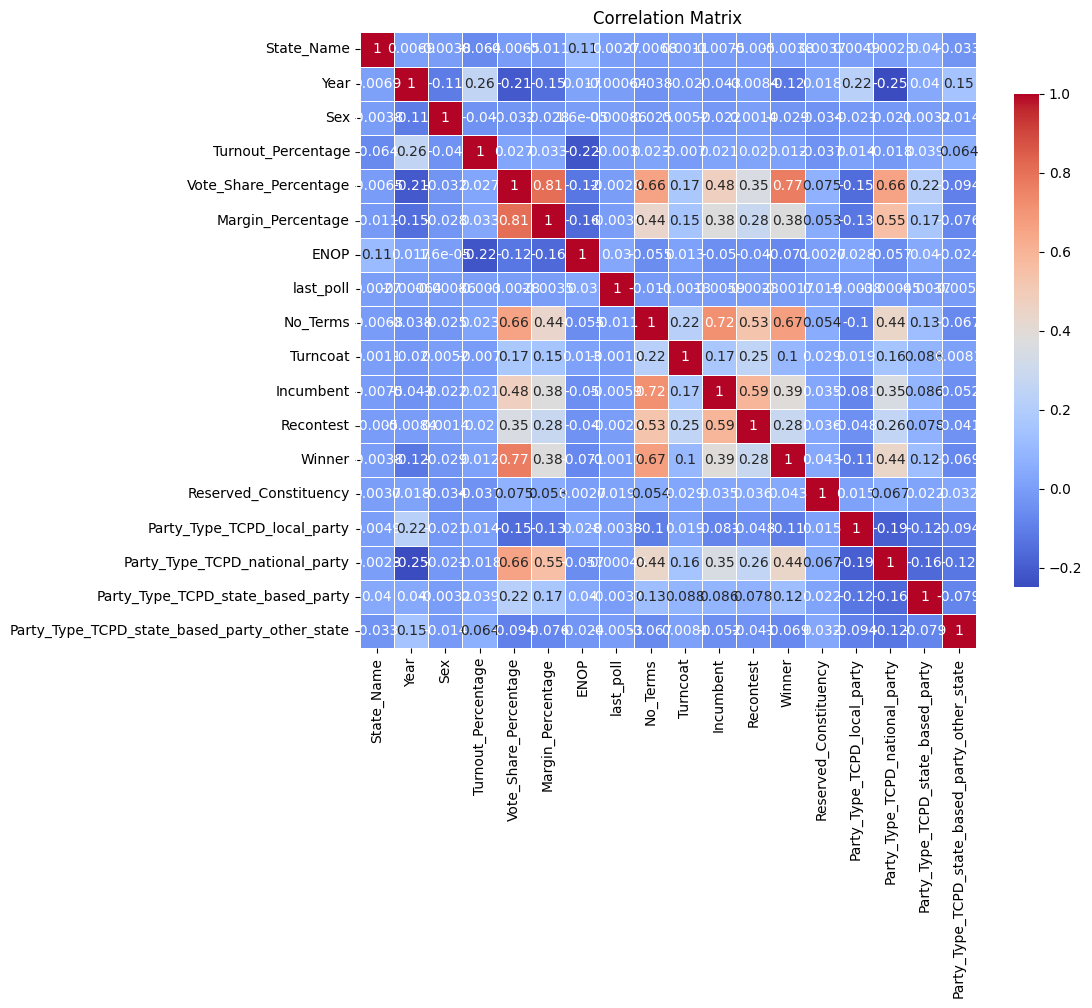

In [245]:
input_cols = ['State_Name', 'Year', 'Sex', 'Turnout_Percentage', 'ENOP', 'last_poll',
       'No_Terms', 'Turncoat', 'Incumbent', 'Recontest',
       'Reserved_Constituency', 'Party_Type_TCPD_local_party',
       'Party_Type_TCPD_national_party', 'Party_Type_TCPD_state_based_party',
       'Party_Type_TCPD_state_based_party_other_state']
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={'shrink': .8}, linewidths=0.5)
plt.title("Correlation Matrix")
plt.savefig('correlation_matrix.png')
plt.show()


In [246]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Split the data
X = df[input_cols]
y = df[ 'Winner']
#'Vote_Share_Percentage', 'Margin_Percentage','Winner'


In [247]:
df[input_cols]

,State_Name,Year,Sex,Turnout_Percentage,ENOP,last_poll,No_Terms,Turncoat,Incumbent,Recontest,Reserved_Constituency,Party_Type_TCPD_local_party,Party_Type_TCPD_national_party,Party_Type_TCPD_state_based_party,Party_Type_TCPD_state_based_party_other_state
0,0,2019,1,65.09,2.38,1,1.0,0,0,1,0,0,1,0,0
1,0,2019,1,65.09,2.38,1,0.0,0,0,0,0,0,1,0,0
2,0,2019,1,65.09,2.38,1,0.0,0,0,0,0,0,0,0,0
3,0,2019,1,65.09,2.38,1,0.0,0,0,1,0,0,0,0,1
4,0,2019,1,65.09,2.38,1,0.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91664,17,1965,1,26.50,1.89,1,0.0,0,0,0,0,0,1,0,0
91665,34,1965,1,17.56,2.17,1,1.0,0,0,0,1,0,1,0,0
91666,34,1965,1,17.56,2.17,1,0.0,0,0,0,1,0,0,0,0
91667,34,1965,1,17.56,2.17,1,0.0,0,0,0,1,0,0,0,0


In [248]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [250]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Evaluate the Logistic Regression model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.97
Confusion Matrix:
[[15223   310]
 [  157  1511]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     15533
           1       0.83      0.91      0.87      1668

    accuracy                           0.97     17201
   macro avg       0.91      0.94      0.93     17201
weighted avg       0.97      0.97      0.97     17201



In [251]:
# Save the Model

import joblib

# After training your model
joblib.dump(model, 'election_model.joblib')

['election_model.joblib']